# Lab work 8
## Numerical solving of the diffusion equation

We consider an 1-dimensional diffusion equation $$ -\frac{d}{dx}(k(x)y'(x)) + u(x)y'(x) = f(x) $$ on the interval $[a,b]$ 

## 1. Finite difference scheme

We make a finite-volume approximation with second order of accuracy on the nonuniform grid:
$$ Dy + C y = f(x) $$
where $ D = -\frac{d}{dx}\left(k(x)\frac{d}{dx}\right) $ and $ C = C_1 = u(x)\frac{d}{dx} $

This method lets us integrate our task by some interval and get the formula for the second derivative $y''$.

So, the operators can be written as follows:
$$ (Dy)_i = -\frac{1}{h_i} \left(k_{i+1/2} \frac{y_{i+1} - y_i}{h_i} - k_{i-1/2} \frac{y_i - y_{i-1}}{h_i} \right) $$
$$ (C_1 y)_i = \frac{1}{h_i} \left(u_{i+1/2} \frac{y_{i+1} - y_i}{2} + u_{i-1/2} \frac{y_i - y_{i-1}}{2} \right) $$

Solving this system, if let boundary conditions $ y(a) = y(b) = 0 $, we get a tridiagonal matrix, which can be solved previously learned methods.

It can be solved that if the Peclet number $ pe = \frac{u_i \cdot h_i}{k_i} < 2 $, then the solution is monotonous.

In [320]:
import numpy as np
import matplotlib.pyplot as plt
import random

# -(k(x)y')' + u(x)y' = f(x)
# y = sin(x)

y_real = lambda x: np.sin(x)
k = lambda x: 1
u = lambda x: x
f = lambda x: x*np.cos(x) + np.sin(x)

# 0 < x < pi
n = 100
a = 0
b = np.pi

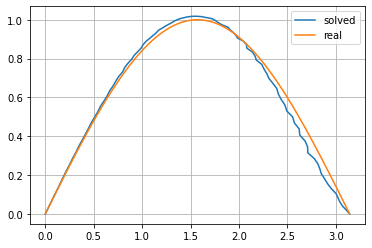

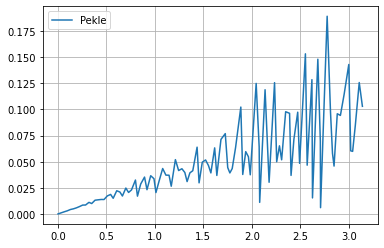

In [321]:
def tridiag(A, b):
    n = b.size
    alpha = np.diagonal(A, offset = -1)
    beta = np.diagonal(A)
    gamma = np.diagonal(A, offset = 1)
    
    P = np.zeros(n)
    P[0] = -gamma[0] / beta[0]
    for i in range(1, n-1):
        P[i] = gamma[i] / (-beta[i] - alpha[i-1]*P[i-1])
    P[n-1] = 0
    
    Q = np.zeros(n)
    Q[0] = b[0] / beta[0]
    for i in range(1, n):
        Q[i] = (alpha[i-1]*Q[i-1] - b[i]) / (-beta[i] - alpha[i-1]*P[i-1])
        
    x = np.zeros(n)
    x[n-1] = Q[n-1]
    for i in range(n-2, -1, -1):
        x[i] = P[i]*x[i+1] + Q[i]
        
    return x

def finiteVolume(x, k, u, f):
    n = len(x)
    pe = np.zeros(n)
    A = np.zeros((n,n))
    F = np.zeros(n)
    
    F[0] = 0
    A[0][0] = 1
    pe[0] = u(x[0]) * (x[1] - x[0]) / k(x[0])
    for i in range(1, n-1):
        pe[i] = u(x[i]) * (x[i] - x[i-1]) / k(x[i])
        A[i][i-1] = -(u(x[i])+u(x[i-1]))/2/2/(x[i]-x[i-1]) - (k(x[i])+k(x[i-1]))/2/((x[i]-x[i-1])**2)
        A[i][i] = (u(x[i-1])-u(x[i+1]))/2/2/(x[i]-x[i-1]) + (k(x[i])+k(x[i-1]))/2/((x[i]-x[i-1])**2) + (k(x[i+1])+k(x[i]))/2/((x[i] - x[i-1])**2)
        A[i][i+1] = (u(x[i+1])+u(x[i]))/2/2/(x[i]-x[i-1]) - (k(x[i+1])+k(x[i]))/2/((x[i]-x[i-1])**2)
        F[i] = f(x[i])
    F[-1] = 0
    A[-1][-1] = 1
    pe[-1] = u(x[-1]) * (x[-1] - x[-2]) / k(x[-1])
    
    res = tridiag(A, F)
    return res, pe

            
# make a nonuniform grid:
# make a standard grid with step = h and add some random real number from [-h/2, h/2]

x = np.zeros(n)
x[0] = a
for i in range(1, n-1):
    x[i] = ((b-a)*i/(n-1))*random.uniform(1-((b-a)/(n-1)/4), 1+((b-a)/(n-1)/4))
x[-1] = b

res, pe = finiteVolume(x, k, u, f)
plt.figure(1)
plt.plot(x, res, label='solved')
plt.plot(x, y_real(x), label='real')
plt.grid()
plt.legend()

plt.figure(2)
plt.plot(x, pe, label='Pekle')
plt.grid()
plt.legend()
plt.show()
plt.show()

## 1.1 Accuracy

Order of accuracy =  2.014444616471506


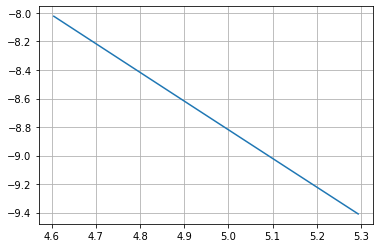

In [310]:
index = np.log([i for i in range(n, 2*n)])
value = np.log([max(abs(finiteVolume(np.linspace(a, b, i), k, u, f)[0] - y_real(np.linspace(a, b, i)))) for i in range(n, 2*n)])
a1, b1 = np.polyfit(index, value, 1)
print("Order of accuracy = ", -a1)
plt.plot(index, value)
plt.grid()
plt.show()

## 2. Monotonized scheme

Sometimes Peclet number is more than 2. Then let's make a new scheme to fix it.  
We will change $k(x)$ when this inequality is wrong: $ k_{new}(x) = (1 + \rho)k(x) $   
Solving a equation, we get the next formula for $\rho$:
$$
\rho = \begin{cases}
   0, pe < 2 \\
   \frac{pe}{2}, pe >= 2
 \end{cases}
$$

In [311]:
# -(k(x)y')' + u(x)y' = f(x)
# y = sin(x)
m = 3

y_real = lambda x: np.sin(m*x)
k = lambda x: 1
u = lambda x: 400*x
f = lambda x: m*400*x*np.cos(m*x) + m**2*np.sin(m*x)

# 0 < x < pi
n = 100
a = 0
b = np.pi/m

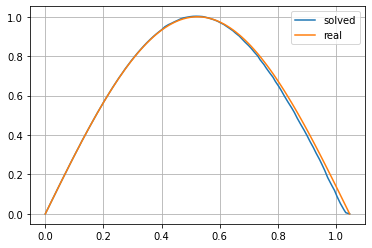

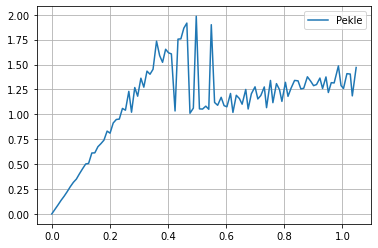

In [312]:
def finiteVolume(x, k, u, f):
    n = len(x)
    pe = np.zeros(n)
    A = np.zeros((n,n))
    F = np.zeros(n)
    
    F[0] = 0
    A[0][0] = 1
    pe[0] = u(x[0]) * (x[1] - x[0]) / k(x[0])
    for i in range(1, n-1):
        pe[i] = u(x[i]) * (x[i] - x[i-1]) / k(x[i])
        A[i][i-1] = -(u(x[i])+u(x[i-1]))/2/2/(x[i]-x[i-1]) - (k(x[i])+k(x[i-1]))/2/((x[i]-x[i-1])**2)
        A[i][i] = (u(x[i-1])-u(x[i+1]))/2/2/(x[i]-x[i-1]) + (k(x[i])+k(x[i-1]))/2/((x[i]-x[i-1])**2) + (k(x[i+1])+k(x[i]))/2/((x[i] - x[i-1])**2)
        A[i][i+1] = (u(x[i+1])+u(x[i]))/2/2/(x[i]-x[i-1]) - (k(x[i+1])+k(x[i]))/2/((x[i]-x[i-1])**2)
        F[i] = f(x[i])
    F[-1] = 0
    A[-1][-1] = 1
    pe[-1] = u(x[-1]) * (x[-1] - x[-2]) / k(x[-1])
    
    res = tridiag(A, F)
    return res, pe

def monotonized(x, k, u, f):
    n = len(x)
    pe = np.zeros(n)
    A = np.zeros((n,n))
    F = np.zeros(n)
    k_new = np.zeros(n)
    
    k_new[0] = k(x[0])
    pe[0] = u(x[0]) * (x[1] - x[0]) / k_new[0]
    for i in range(1, n):
        pekle = u(x[i]) * (x[i] - x[i-1]) / k(x[i])
        if(pekle < 2):
            k_new[i] = k(x[i])
            pe[i] = pekle            
        else:
            k_new[i] = k(x[i])*(1 + pekle/2)
            pe[i] = u(x[i]) * (x[i] - x[i-1]) / k_new[i]
            
    F[0] = 0
    A[0][0] = 1
    for i in range(1, n-1):
        A[i][i-1] = -(u(x[i])+u(x[i-1]))/2/2/(x[i]-x[i-1]) - (k_new[i]+k_new[i-1])/2/((x[i]-x[i-1])**2)
        A[i][i] = (u(x[i-1])-u(x[i+1]))/2/2/(x[i]-x[i-1]) + (k_new[i]+k_new[i-1])/2/((x[i]-x[i-1])**2) + (k_new[i+1]+k_new[i])/2/((x[i] - x[i-1])**2)
        A[i][i+1] = (u(x[i+1])+u(x[i]))/2/2/(x[i]-x[i-1]) - (k_new[i+1]+k_new[i])/2/((x[i]-x[i-1])**2)    
        F[i] = f(x[i])
    F[-1] = 0
    A[-1][-1] = 1
    
    res = tridiag(A, F)
    return res, pe

x = np.zeros(n)
x[0] = a
for i in range(1, n-1):
    x[i] = ((b-a)*i/(n-1))*random.uniform(1-((b-a)/(n-1)/4), 1+((b-a)/(n-1)/4))
x[-1] = b

res, pe = monotonized(x, k, u, f)
plt.figure(1)
plt.plot(x, res, label='solved')
plt.plot(x, y_real(x), label='real')
plt.grid()
plt.legend()

plt.figure(2)
plt.plot(x, pe, label='Pekle')
plt.grid()
plt.legend()
plt.show()
plt.show()

## 2.1 Accuracy

Order of accuracy =  1.3603425847968602


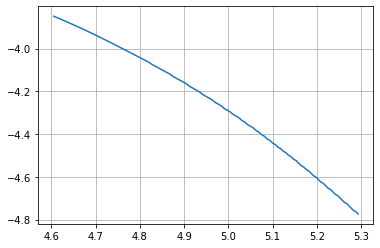

In [313]:
index = np.log([i for i in range(n, 2*n)])
value = np.log([max(abs(monotonized(np.linspace(a, b, i), k, u, f)[0] - y_real(np.linspace(a, b, i)))) for i in range(n, 2*n)])
a1, b1 = np.polyfit(index, value, 1)
print("Order of accuracy = ", -a1)
plt.plot(index, value)
plt.grid()
plt.show()

## 3. Unconditional monotonous scheme

Our operational differential eqution is:
$$ Dy + C y = f(x) $$
where $ D = -\frac{d}{dx}\left(k(x)\frac{d}{dx}\right) $ and $ C = C_1 = u(x)\frac{d}{dx} $

To make a monotonous scheme, we can define operators C as:
$$ (C y)_i = \frac{1}{h_i} \left(u^{+}_{i+1/2} y_i  + u^{-}_{i+1/2} y_{i+1} - u^{+}_{i-1/2} y_{i-1}  + u^{-}_{i-1/2} y_{i} \right) $$
where $$ u^{+}_{i+1/2} = \frac{1}{2} (u_{i+1/2} + |u_{i+1/2}|) $$
$$ u^{-}_{i+1/2} = \frac{1}{2} (u_{i+1/2} - |u_{i+1/2}|) $$

In [314]:
# -(k(x)y')' + u(x)y' = f(x)
# y = sin(x)
m = 3

y_real = lambda x: np.sin(m*x)
k = lambda x: 1
u = lambda x: 400*x
f = lambda x: m*400*x*np.cos(m*x) + m**2*np.sin(m*x)

# 0 < x < pi
n = 100
a = 0
b = np.pi/m

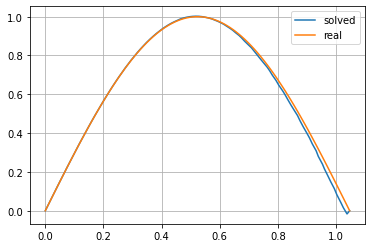

In [315]:
def unconditional(x, k, u, f):
    n = len(x)
    pe = np.zeros(n)
    A = np.zeros((n,n))
    F = np.zeros(n)
    
    F[0] = 0
    A[0][0] = 1
    pe[0] = u(x[0]) * (x[1] - x[0]) / k(x[0])
    for i in range(1, n-1):
        pe[i] = u(x[i]) * (x[i] - x[i-1]) / k(x[i])
        u_plus_up = (u(x[i+1])+u(x[i]))/2 + abs((u(x[i+1])+u(x[i]))/2)/2
        u_plus_down = (u(x[i])+u(x[i-1]))/2 + abs((u(x[i])+u(x[i-1]))/2)/2
        u_minus_up = (u(x[i+1])+u(x[i]))/2 - abs((u(x[i+1])+u(x[i]))/2)/2
        u_minus_down = (u(x[i])+u(x[i-1]))/2 - abs((u(x[i])+u(x[i-1]))/2)/2
        A[i][i-1] = -u_plus_down/(x[i]-x[i-1]) - k(x[i])/((x[i]-x[i-1])**2)
        A[i][i] = u_plus_up/(x[i]-x[i-1]) - u_minus_down/(x[i]-x[i-1]) + 2*k(x[i])/((x[i]-x[i-1])**2)
        A[i][i+1] = u_minus_up/(x[i]-x[i-1]) - k(x[i])/((x[i]-x[i-1])**2)
        F[i] = f(x[i])
    F[-1] = 0
    A[-1][-1] = 1
    pe[-1] = u(x[-1]) * (x[-1] - x[-2]) / k(x[-1])
    
    res = tridiag(A, F)
    return res, pe

            
# make a nonuniform grid:
# make a standard grid with step = h and add some random real number from [-h/2, h/2]

x = np.zeros(n)
x[0] = a
for i in range(1, n-1):
    x[i] = ((b-a)*i/(n-1))*random.uniform(1-((b-a)/(n-1)/4), 1+((b-a)/(n-1)/4))
x[-1] = b

res, pe = monotonized(x, k, u, f)
plt.figure(1)
plt.plot(x, res, label='solved')
plt.plot(x, y_real(x), label='real')
plt.grid()
plt.legend()

## 3.1 Accuracy

Order of accuracy =  1.3603425847968602


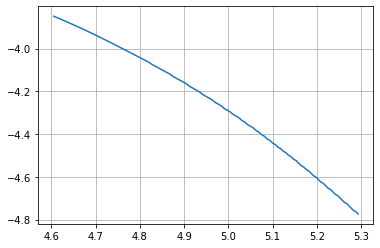

In [316]:
index = np.log([i for i in range(n, 2*n)])
value = np.log([max(abs(monotonized(np.linspace(a, b, i), k, u, f)[0] - y_real(np.linspace(a, b, i)))) for i in range(n, 2*n)])
a1, b1 = np.polyfit(index, value, 1)
print("Order of accuracy = ", -a1)
plt.plot(index, value)
plt.grid()
plt.show()